Epoch 1/50
4/4 [==============================] - 7s 917ms/step - loss: 4.9086 - accuracy: 0.1583
Epoch 2/50
4/4 [==============================] - 4s 885ms/step - loss: 4.7488 - accuracy: 0.3167
Epoch 3/50
4/4 [==============================] - 4s 893ms/step - loss: 4.5960 - accuracy: 0.3000
Epoch 4/50
4/4 [==============================] - 4s 910ms/step - loss: 4.5279 - accuracy: 0.2833
Epoch 5/50
4/4 [==============================] - 4s 904ms/step - loss: 4.3678 - accuracy: 0.3500
Epoch 6/50
4/4 [==============================] - 4s 905ms/step - loss: 4.4050 - accuracy: 0.2833
Epoch 7/50
4/4 [==============================] - 4s 911ms/step - loss: 4.3686 - accuracy: 0.2917
Epoch 8/50
4/4 [==============================] - 4s 917ms/step - loss: 4.2755 - accuracy: 0.3583
Epoch 9/50
4/4 [==============================] - 4s 920ms/step - loss: 4.2449 - accuracy: 0.3250
Epoch 10/50
4/4 [==============================] - 4s 919ms/step - loss: 4.2133 - accuracy: 0.3500
Epoch 11/50
4/4 [==

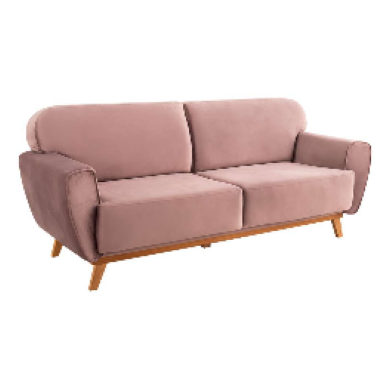

1/1 [==============================] - 0s 41ms/step
Nome Produto Avaliação: Conjunto de Mesa de Jantar Luna com Vidro e 6 Cadeiras Grécia Veludo Chocolate e Off White
Categoria Prevista: Armário Cozinha
Probabilidade: 0.95
Cores Identificadas: ['white', 'lightgray', 'silver']


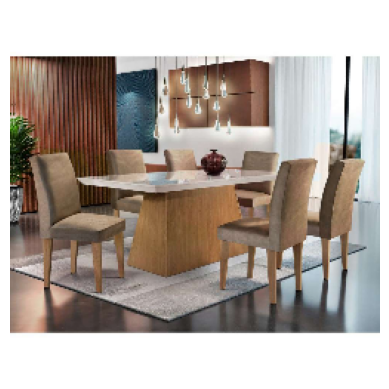

1/1 [==============================] - 0s 41ms/step
Nome Produto Avaliação: Guarda-Roupa Casal Premium 6 PT 6 GV Neve
Categoria Prevista: nan
Probabilidade: 0.60
Cores Identificadas: ['lightgray']


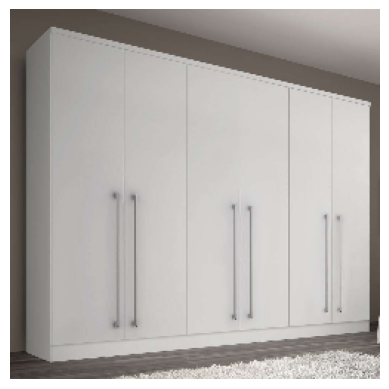

1/1 [==============================] - 0s 43ms/step
Nome Produto Avaliação: Cadeira de Escritório Presidente Giratória com Relax Finland Preta
Categoria Prevista: Fruteira
Probabilidade: 0.34
Cores Identificadas: ['dimgray', 'darkgray', 'gainsboro', 'whitesmoke', 'lightgray', 'gray', 'white']


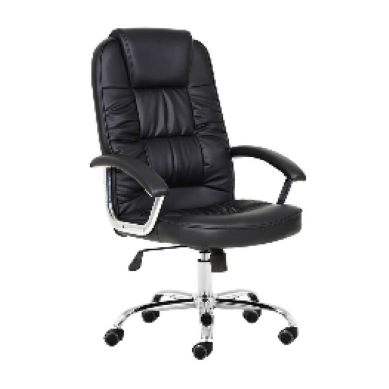

1/1 [==============================] - 0s 40ms/step
Nome Produto Avaliação: Cadeira de Escritório Secretária Giratória Marilyn Branca
Categoria Prevista: Armário Cozinha
Probabilidade: 0.91
Cores Identificadas: ['white', 'lightgray']


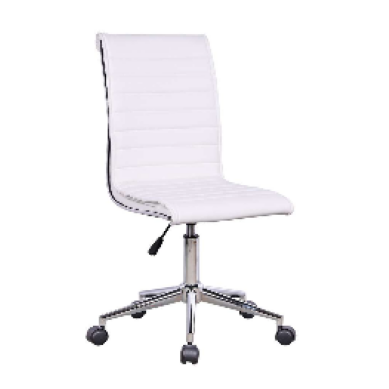

1/1 [==============================] - 0s 40ms/step
Nome Produto Avaliação: Conjunto de Mesa de Jantar Berlim II com Tampo de Vidro Off White e 4 Cadeiras Grécia Veludo Creme
Categoria Prevista: Armário Cozinha
Probabilidade: 1.00
Cores Identificadas: ['white', 'gainsboro']


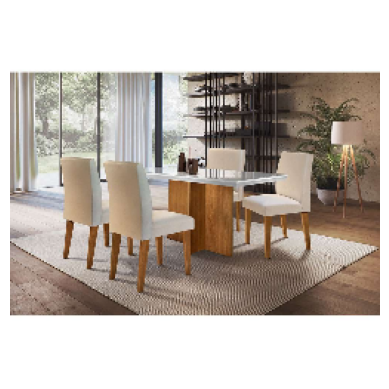

1/1 [==============================] - 0s 40ms/step
Nome Produto Avaliação: Conjunto Sala de Jantar Madesa Talita Mesa Tampo de Madeira com 4 Cadeiras - Rustic/Crema/Pérola
Categoria Prevista: Kit Cozinha
Probabilidade: 0.53
Cores Identificadas: []


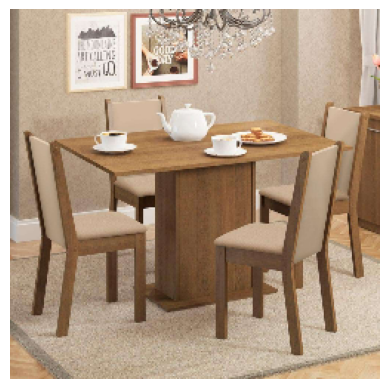

1/1 [==============================] - 0s 55ms/step
Nome Produto Avaliação: Sofá 2 Lugares Vitrola Suede Tabaco
Categoria Prevista: Balcão de Cozinha
Probabilidade: 0.93
Cores Identificadas: []


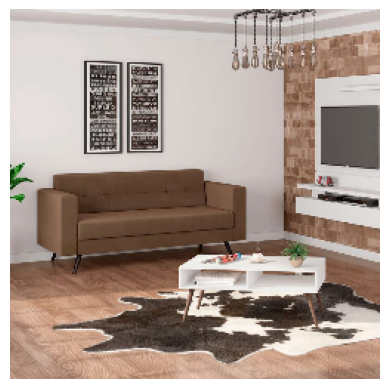

1/1 [==============================] - 0s 38ms/step
Nome Produto Avaliação: Sofá na Caixa Ubbe 3 Lugares com Molas Ensacadas Bouclê Cinza 200 cm
Categoria Prevista: Armário Cozinha
Probabilidade: 0.84
Cores Identificadas: ['silver', 'darkgray']


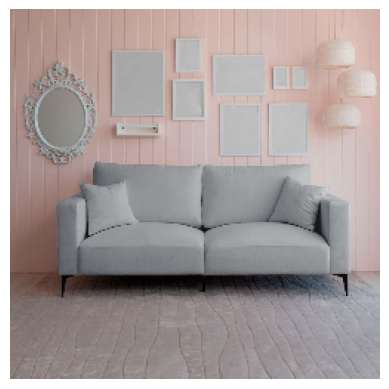

1/1 [==============================] - 0s 37ms/step
Nome Produto Avaliação: Cômoda Colors Madeira Maciça 6 GV Castanho Verniz e Colorido Envelhecido
Categoria Prevista: Balcão de Cozinha
Probabilidade: 0.76
Cores Identificadas: ['white']


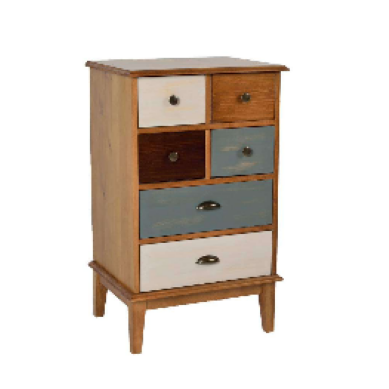

1/1 [==============================] - 0s 51ms/step
Nome Produto Avaliação: Cômoda Vegas 4 GV Natural Rustico
Categoria Prevista: Balcão de Cozinha
Probabilidade: 0.54
Cores Identificadas: ['white']


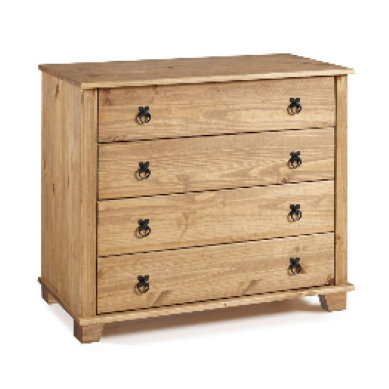

In [10]:
import cv2
import numpy as np
import os
import pandas as pd
import requests
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Flatten,
    concatenate,
    Conv2D,
    MaxPooling2D,
    LSTM,
    Dropout,
    Dense,
    GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from typing import List
import webcolors


def identify_colors(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    small_image = cv2.resize(image_rgb, (100, 100))
    color_list = small_image.reshape(-1, small_image.shape[-1])
    color_names = []
    for color in color_list:
        try:
            closest_color = webcolors.rgb_to_name(color)
            color_names.append(closest_color)
        except ValueError:
           
            pass
    return list(set(color_names))


def process_image(image_path: str) -> np.ndarray:
    if image_path.startswith('http'):
        response = requests.get(image_path)
        if response.status_code == 200:
            img_data = BytesIO(response.content)
            img = cv2.imdecode(np.frombuffer(img_data.read(), np.uint8), 1)
            if img is not None:
                img = cv2.resize(img, (250, 250))
                return img
    elif os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.resize(img, (250, 250))
            return img
    return None


root_dir = r'D:\imagesapp\images'
treino = pd.read_csv(os.path.join(root_dir, 'images.csv'), sep=";")
avaliacao = pd.read_csv(os.path.join(root_dir, 'avaliacao.csv'), sep=";")

if treino is not None and avaliacao is not None:
    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(treino['Categoria'])
    num_classes = len(label_encoder.classes_)

    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(treino['nome'])

    texts_train_sequences = tokenizer.texts_to_sequences(treino['nome'])
    max_sequence_length = 100
    texts_train_sequences = pad_sequences(texts_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
    text_vocab_size = len(tokenizer.word_index) + 1

    image_shape = (250, 250, 3)
    text_shape = (max_sequence_length,)

    input_image = Input(shape=image_shape)
    image_model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
    ])
    image_output = image_model(input_image)

    input_text = Input(shape=text_shape, dtype=tf.int32)
    text_model = tf.keras.Sequential([
        Embedding(input_dim=text_vocab_size, output_dim=128, input_length=max_sequence_length),
        LSTM(128, return_sequences=True),
        LSTM(128, return_sequences=True),
        GlobalAveragePooling1D(),
    ])
    text_output = text_model(input_text)

    combined = concatenate([image_output, text_output])
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', name='Categoria')(x)

    model = Model(inputs=[input_image, input_text], outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    images_train = np.array([process_image(image) for image in treino['img0']])

    model.fit([images_train, texts_train_sequences], labels_train_encoded, epochs=50, batch_size=32)

    exemplos_avaliacao = avaliacao['nome'].tolist()
    imagens_avaliacao = [process_image(image) for image in avaliacao['imagem']]

    print("Resultados para produtos de avaliação:")
    for nome, imagem in zip(exemplos_avaliacao, imagens_avaliacao):
        if imagem is not None:
            texto_exemplo = nome
            texto_exemplo_sequence = tokenizer.texts_to_sequences([texto_exemplo])
            texto_exemplo_sequence = pad_sequences(texto_exemplo_sequence, maxlen=max_sequence_length, padding='post', truncating='post')
            previsao_probabilidades = model.predict([np.array([imagem]), texto_exemplo_sequence])
            categoria_prevista = np.argmax(previsao_probabilidades)
            categoria_prevista_label = label_encoder.inverse_transform([categoria_prevista])[0]

            cores_identificadas = identify_colors(imagem)

            print(f'Nome Produto Avaliação: {nome}')
            print(f'Categoria Prevista: {categoria_prevista_label}')
            print(f'Probabilidade: {previsao_probabilidades[0][categoria_prevista]:.2f}')
            print(f'Cores Identificadas: {cores_identificadas}')
            plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()




In [3]:
treino = pd.read_csv(r"D:\imagesapp\images\images.csv",sep=";")
treino.columns

Index(['nome', 'img0', 'img1', 'img2', 'img3', 'Categoria'], dtype='object')

In [4]:
teste = pd.read_csv(r"D:\imagesapp\images\avaliacao.csv",sep=";")
treino = pd.read_csv(r"D:\imagesapp\images\images.csv",sep=";")

In [5]:
treino

,nome,img0,img1,img2,img3,Categoria
0,Cozinha Compacta Iluminata 8 PT 4 GV Branca e ...,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,Kit Cozinha
1,Armário aéreoeo Canelone com Vidro 3 PT Preto,https://static.mobly.com.br/p/2000x2000/p/Poli...,https://static.mobly.com.br/p/2000x2000/p/Poli...,https://static.mobly.com.br/p/2000x2000/p/Poli...,https://static.mobly.com.br/p/2000x2000/p/Poli...,Armário Cozinha
2,Armário aéreoeo Evidence 3 PT Branco 120 cm,https://static.mobly.com.br/p/2000x2000/p/Poli...,https://static.mobly.com.br/p/2000x2000/p/Poli...,https://static.mobly.com.br/p/2000x2000/p/Poli...,NaN,Armário Cozinha
3,Balcão de Cozinha Iluminata 2 PT Mint 80 cm,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,https://static.mobly.com.br/p/2000x2000/p/GENI...,Balcão de Cozinha
4,Paneleiro Maxxi 2 PT Branco,https://static.mobly.com.br/p/2000x2000/p/Kapp...,https://static.mobly.com.br/p/2000x2000/p/Kapp...,https://static.mobly.com.br/p/2000x2000/p/Kapp...,https://static.mobly.com.br/p/2000x2000/p/Kapp...,Paneleiro
...,...,...,...,...,...,...
115,Cômoda Premium 5 GV Neve,https://static.mobly.com.br/r/2000x2000/p/Mode...,NaN,NaN,NaN,Comoda Quarto
116,Sofá 2 Lugares Retrátil Urban com Entrada USB ...,https://static.mobly.com.br/r/2000x2000/p/Esto...,NaN,NaN,NaN,Sofá Sala
117,Sofá 3 Lugares Floret Veludo Rosê,https://static.mobly.com.br/r/2000x2000/p/Keva...,NaN,NaN,NaN,Sofá Sala
118,Guarda-Roupa Casal Mônaco 6 PT 2 GV Naturale e...,https://static.mobly.com.br/r/2000x2000/p/Mobl...,NaN,NaN,NaN,NaN


In [6]:
teste = pd.read_csv(r"D:\imagesapp\images\avaliacao.csv",sep=";")
teste

,nome,imagem
0,Sofá 3 Lugares Floret Veludo Rosê,https://static.mobly.com.br/r/2000x2000/p/Keva...
1,Conjunto Sala de Jantar Cíntia Madesa Mesa Tam...,https://static.mobly.com.br/r/2000x2000/p/Made...
2,Conjunto de Mesa de Jantar Luna com Vidro e 6 ...,https://static.mobly.com.br/r/2000x2000/p/Mode...
3,Guarda-Roupa Casal Premium 6 PT 6 GV Neve,https://static.mobly.com.br/r/2000x2000/p/Mobl...
4,Cadeira de Escritório Presidente Giratória com...,https://static.mobly.com.br/r/2000x2000/p/Mobl...
5,Cadeira de Escritório Secretária Giratória Mar...,https://static.mobly.com.br/r/2000x2000/p/Mobl...
6,Conjunto de Mesa de Jantar Berlim II com Tampo...,https://static.mobly.com.br/r/2000x2000/p/Mode...
7,Conjunto Sala de Jantar Madesa Talita Mesa Tam...,https://static.mobly.com.br/r/2000x2000/p/Made...
8,Sofá 2 Lugares Vitrola Suede Tabaco,https://static.mobly.com.br/r/2000x2000/p/Mode...
9,Sofá na Caixa Ubbe 3 Lugares com Molas Ensacad...,https://static.mobly.com.br/r/2000x2000/p/Keva...
